# Tutorial: Logistic Regression for Factor Mapping 

This tutorial replicates a scenario discovery analysis performed in [Hadjimichael et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020EF001503).

## Background
Planners in the the Upper Colorado River Basin (UCRB, shown in the figure below) are seeking to understand the vulnerability of water users to uncertainties stemming from climate change, population growth and water policy changes. The UCRB spans 25,682 km<sup>2</sup> in western Colorado and is home to approximately 300,000 residents and 1,012 km<sup>2</sup> of irrigated land. Several thousand irrigation ditches divert water from the main river and its tributaties for irrigation (shown as small black dots in the figure). Transmountain diversions of approximately 567,4000,000 m<sup>3</sup> per year are exported for irrigation, industrial and municipal uses in northern and eastern Colorado, serving the major population centers of Denver and Colorado Springs. These diversions are carried through tunnels, shown as large black dots in the figure.

An important planning consideration is the water rights of each user, defined by seniority across all water uses (irrigation diversions, transboundary diversions, power plants etc.) in the basin. To assess the vulnerability of users with varying degrees of water rights seniority, planners simulate the system across an ensemble of scenarios using the state of Colorado's StateMod platform. The model simulates streamflow, diversions, instream demands, and reservoir operations. 

<img src="./figs/basin_map.png" width="600">

Focusing on decision-relevant metrics, the scenario discovery is applied to the water shortages experienced by each individual user (i.e., not on a single basin-wide or sector-wide metric). For this training example, we'll be performing scenario discovery for three different water users, two irrigation users and one municipal user.



Before we start our analysis, we'll load the relevant Python libraries and create lists storing the names of the users of interest.

In [1]:
import msdbook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# load example data
msdbook.install_package_data()

all_IDs = ['7000550','7200799','3704614'] # IDs for three that we will perform the analysis for
usernames = ['Medium seniority irrigation',
             'Low seniority irrigation',
             'Transbasin municipal diversion']
nStructures = len(all_IDs)


Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/uncertain_params_bounds.txt
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/sa_metric_s1.npy
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/sa_vary_delta.npy
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/sa_by_mth_s1.npy
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/solutions.resultfile
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/3704614_heatmap.npy
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/LHsamples_original_1000.txt
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/3704614_pseudo_r_scores.csv
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/param_values.csv
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/data/sa_by_yr_s1.npy
Unzipped: /Users/d3y010/repos/github/msd_uncertainty_ebook/msdbook/dat

## Step 1:  Load Latin Hypercube Sample and set up problem
To examine regional vulnerability, we generate an ensemble of plausible future states of the worlds (SOWs) using Latin Hypercube Sampling. For this tutorial, we'll load a file containing 1,000 parameter samples. 

In [3]:
LHsamples = msdbook.load_lhs_basin_sample()
param_bounds = msdbook.load_basin_param_bounds()

param_names=['Irrigation demand multiplier','Reservoir loss','Transbasin demand multiplier',
             'Municipal & industrial multiplier', 'Shoshone','Environmental flows',
             'Evaporation change','Mean dry flow','Dry flow variance',
             'Mean wet flow','Wet flow variance','Dry-dry probability',
             'Wet-wet probability', 'Snowmelt shift']


## Step 2: Define decision-relevant metrics for illustration
Scenario discovery attempts to identify parametric regions that lead to 'success' and 'failure'. For this demonstration we'll be defining 'success' as states of the world where a shortage level doesn't exceed its historical frequency.

## Step 3: Run the logistic regression
Logistic regression estimates the probability that a future SOW will be classified as a success or failure given a set of performance criteria. A logistic regression model is defined by:

$$ln \bigg (\frac{p_i}{1-p_i} \bigg ) = X^T_i \beta$$

where $p_i$ is the probability the performance in the $i^{th}$ SOW will be classified as a success, $X_i$ is the vector of covariates describing the $i^{th}$ SOW, and $\beta$ is the vector of coefficients describing the relationship between the covariates and the response, which here will be estimated using maximum likelihood estimation. 

A logistic regression model was fit to the ensemble of SOWs using the performance criteria defined in step 2. Logistic regression modeling was conducted using the [Statsmodel Python](https://www.statsmodels.org/stable/index.html) package. The data required for the full analysis is too large to include in this tutorial, but results can be found in the data file loaded below.

The results files contain the occurence of different frequency and magnitude combinations under the experiment, in increments of 10, between 0 and 100. These combinations (100 for each user) are alternative decision-relevant metrics that can be used for scenario discovery. 

In [4]:
# Set arrays for shortage frequencies and magnitudes
frequencies = np.arange(10, 110, 10)
magnitudes = np.arange(10, 110, 10)
realizations = 10


# Load performance and pseudo r scores for each of the users
results = [msdbook.load_user_heatmap_array(all_IDs[i]) / 100 for i in range(len(all_IDs))]


## Step 4: Factor ranking
To rank the importance of each uncertain factor, we utilize McFadden's psuedo-R<sup>2</sup>, a measure that quantifies the improvement of the model when utilizing each given predictor as compared to prediction using the mean of the data set:

$$R^2_{McFadden}=1-\frac{ln \hat{L}(M_{full})}{ln \hat{L}(M_{intercept})}$$

Where $ln \hat{L}(M_{full})$ is the log likelihood of the full model (including the predictor) and $ln \hat{L}(M_{intercept})$ is the log likelihood of the intercept model (which predicts the mean probability of success across all SOWs). 

Higher values of McFadden's psuedo-R<sup>2</sup> indicate higher factor importance (when the likelihood of the full model approaches one, the ratio of the likelihood of the full model compared to the intercept model will get very small).




In [5]:
scores = [msdbook.load_user_pseudo_scores(all_IDs[i]) for i in range(len(all_IDs))]

freq = [1,0,0]
mag = [7,3,7]


## Step 5: Draw factor maps

The McFadden's psuedo-R<sup>2</sup> scores files contain preliminary logistic regression results on parameter importance for each of these combinations. Using these psuedo-R<sup>2</sup> scores we will identify the two most important factors for each metric which we'll use to generate the final scenario discovery maps (note: there may be more than two important metrics for each user, but here we will demonstrate by mapping two).

Optimization terminated successfully.
         Current function value: 0.378619
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397285
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377323
         Iterations 8


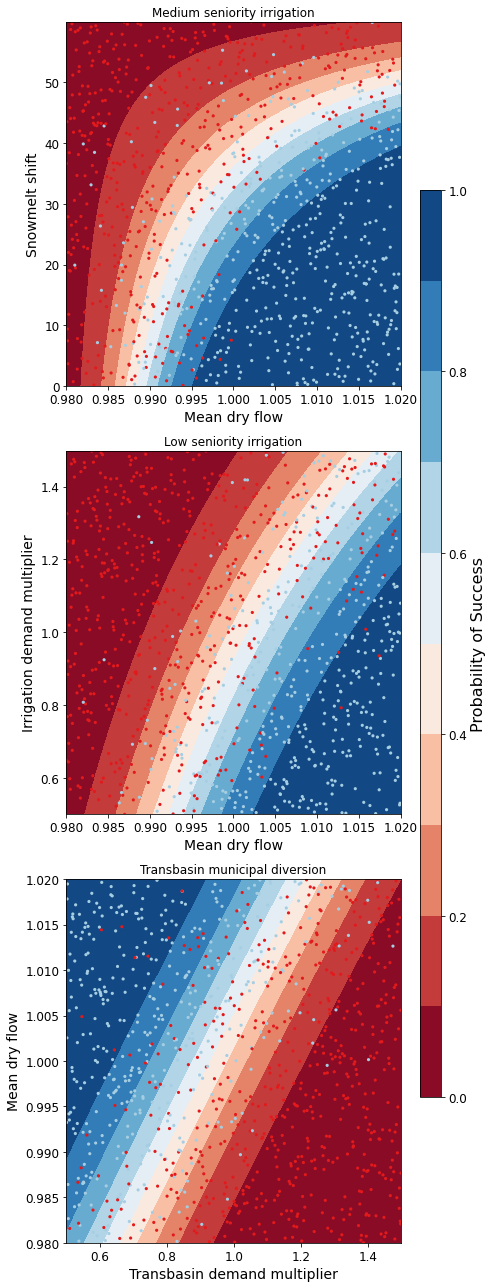

In [6]:
fig, axes = plt.subplots(3,1, figsize=(6,18), tight_layout=True)
fig.patch.set_facecolor('white')

for i in range(len(axes.flat)):
    
    ax = axes.flat[i]
    
    allSOWsperformance = results[i]
    all_pseudo_r_scores = scores[i]
    
    # construct dataframe
    dta = pd.DataFrame(data=np.repeat(LHsamples, realizations, axis = 0), columns=param_names)
    dta['Success'] = allSOWsperformance[freq[i],mag[i],:]
    
    pseudo_r_scores = all_pseudo_r_scores[str(frequencies[freq[i]])+'yrs_'+str(magnitudes[mag[i]])+'prc'].values
    top_predictors = np.argsort(pseudo_r_scores)[::-1][:2] #Sort scores and pick top 2 predictors
    
    # define color map for dots representing SOWs in which the policy
    # succeeds (light blue) and fails (dark red)
    dot_cmap = mpl.colors.ListedColormap(np.array([[227,26,28],[166,206,227]])/255.0)
    
    # define color map for probability contours
    contour_cmap = mpl.cm.get_cmap('RdBu')
    
    # define probability contours
    contour_levels = np.arange(0.0, 1.05,0.1)
    
    # define base values of the predictors
    SOW_values = np.array([1,1,1,1,0,0,1,1,1,1,1,0,0,0]) # default parameter values for base SOW
    base = SOW_values[top_predictors]
    ranges = param_bounds[top_predictors]
    
    # define grid of x (1st predictor), and y (2nd predictor) dimensions
    # to plot contour map over
    xgrid = np.arange(param_bounds[top_predictors[0]][0],
                      param_bounds[top_predictors[0]][1], np.around((ranges[0][1]-ranges[0][0])/500,decimals=4))
    ygrid = np.arange(param_bounds[top_predictors[1]][0],
                      param_bounds[top_predictors[1]][1], np.around((ranges[1][1]-ranges[1][0])/500,decimals=4))
    all_predictors = [ dta.columns.tolist()[i] for i in top_predictors]
    dta['Interaction'] = dta[all_predictors[0]]*dta[all_predictors[1]]
    
    # logistic regression here
    predictor_list = [all_predictors[i] for i in [0,1]]
    result = msdbook.fit_logit(dta, predictor_list)
    
    # plot contour map
    contourset = msdbook.plot_contour_map(ax, result, dta, contour_cmap,
                                          dot_cmap, contour_levels, xgrid,
                                          ygrid, all_predictors[0], all_predictors[1], base)
    
    ax.set_title(usernames[i])
    
# set up colorbar
cbar_ax = fig.add_axes([0.98, 0.15, 0.05, 0.7])
cbar = fig.colorbar(contourset, cax=cbar_ax)
cbar_ax.set_ylabel('Probability of Success', fontsize=16)
cbar_ax.tick_params(axis='y', which='major', labelsize=12)


The figure above demonstrates how different combinations of the uncertain factors lead to success or failure in different states of the world, which are denoted by the blue and red dots. The probability of success and failure are further denoted by the contours in the figure. Several insights can be drawn from this figure.

First, using metrics chosen to be decision-relevant (specific to each
user) causes different factors to be identified as most important by this scenario-discovery
exercise (the x- and y-axes for each of the subplots). In other words, depending
on what the decision makers of this system want to prioritize they might choose to
monitor different uncertain factors to track performance.

Second, in the top panel, the two identified factors appear to also have an interactive
effect on the metric used (shortages of a certain level and frequency in this example).
In terms of scenario discovery, the Patient Rule Induction Method (PRIM) or Classification
And Regression Trees (CART) would not be able to delineate this non-linear space and
would therefore misclassify parameter combinations as 'desirable' when they were in
fact undesirable, and vice versa.

Lastly, logistic regression also produces contours of probability of success, i.e.
different factor-value combinations are assigned different probabilities that a
shortage level will be exceeded. This allows the decision makers to evaluate these
insights while considering their risk aversion.